# Case 3 -ISKON

## Import required libraries: 

In [142]:
# utilities: 
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime as dt

# visualization: 
import wordcloud as wc
import seaborn as snsr
import scipy as sp


# text cleaning components:
import re
import ast
from deep_translator import GoogleTranslator
from textblob import TextBlob

# nltk components:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# machine learning components: 
from sklearn.feature_extraction import text as skl_text
from sklearn import feature_selection as skl_fsel
from sklearn import model_selection as skl_msel
from sklearn import metrics as skl_met
from sklearn import ensemble as skl_ens
from sklearn import naive_bayes as skl_nb
import imblearn as imb

# AFINN
from afinn import Afinn

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LatiosHaoyang.Guo\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LatiosHaoyang.Guo\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LatiosHaoyang.Guo\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
path = 'IMB767(Enhancing Visitor Experience at ISKON,spreadsheet).xlsx'
data = pd.read_excel(path, sheet_name='data')
print(f'raw data contains {data.shape[0]} rows and {data.shape[1]} features.')
data.head()

raw data contains 5685 rows and 8 features.


,REVIEW ID,SOURCE,REVIEW BY,REVIEW DATE,REVIEW SUBJECT,text,REVIEW RATING,REVIEW TYPE
0,814,Trip Advisor,maryd1928,2013-01-02,Don't miss this Bangalore Temp,Don't miss this Gaudiya Vaishnava Temple locat...,5,POSITIVE
1,1181,Trip Advisor,maryd1928,2013-01-02,Don't miss this Bangalore Temple,Don't miss this Gaudiya Vaishnava Temple locat...,5,POSITIVE
2,813,Trip Advisor,shoubhik,2013-01-05,peacefull and devotional,This was my 2nd visit to the temple.. last tim...,4,POSITIVE
3,1182,Trip Advisor,shoubhik,2013-01-05,peacefull and devotional,This was my 2nd visit to the temple.. last tim...,4,POSITIVE
4,812,Trip Advisor,onthemoveBangalore,2013-01-10,Huge and Grand,The Iskcon temple is a rather grand and imposi...,5,POSITIVE


## Q1 - First Occurrence of Duplicate Reviews - First person same day: 

In [7]:
data_unique_day = data.drop_duplicates(subset=['REVIEW BY', 'REVIEW DATE'], keep = 'first')
print(f'Data retaining only the first review made by a person on the same day - contains {data_unique_day.shape[0]} rows, \
{round(100-(data_unique_day.shape[0]/data.shape[0])*100,1)}% reduction from raw data.')

Data retaining only the first review made by a person on the same day - contains 4645 rows, 18.3% reduction from raw data.


## Q2 - First Occurrence of Duplicate Reviews - First person within 7 day: 

In [8]:
sorted_data = data.sort_values(by=['REVIEW BY', 'REVIEW DATE']).reset_index()
# Iterate the entire sorted data to create drop_flag: 
drop_flag = []
for i, row in sorted_data.iterrows(): 
    if i == 0: 
        # The first row will always be kept
        drop_flag.append(False)
        # Init name keeper
        poi = row['REVIEW BY']
        # Init time keeper
        date = row['REVIEW DATE']
    else: 
        if row['REVIEW BY'] == poi and (row['REVIEW DATE'] - date) <= dt.timedelta(days=7):
            # If reviewer name stays the same and time difference is smaller than 7 days, drop review: 
            drop_flag.append(True)
        elif row['REVIEW BY'] == poi: 
            # If reviewer name stays the same but time difference exceeds 7 days, append review, restart timer: 
            drop_flag.append(False)
            date = row['REVIEW DATE']
        else: 
            # if reviewer changes, restart timer and name keeper: 
            drop_flag.append(False)
            poi = row['REVIEW BY']
            date = row['REVIEW DATE']

# Append drop_flag as a DataFrame feature and apply sorting:
sorted_data['flag'] = drop_flag
data_unique_7day = sorted_data[sorted_data.flag].drop(columns='flag').reset_index(drop=True)

print(f'Data retaining only the first review made by a person with 7 days - contains {data_unique_7day.shape[0]} rows, \
{round(100-(data_unique_7day.shape[0]/data.shape[0])*100,1)}% reduction from raw data.')

Data retaining only the first review made by a person with 7 days - contains 1052 rows, 81.5% reduction from raw data.


### Remove empty rows: 

In [240]:
final_data = data_unique_7day.dropna().reset_index()
print(f'Non-empty data retaining only the first review made by a person with 7 days - contains {final_data.shape[0]} rows')

Non-empty data retaining only the first review made by a person with 7 days - contains 1009 rows


## Q3 - Standard pre-processing technique: 
- contraction replacement
- stop words removal
- number and symbols removal
- lowercasing
- slang correction
- spell correction
- translation to english
- stemming
- lemmatization

### Function pipelines

In [10]:
def diff_log(before:str, after:str, filter: str, verbose=0):
    flag = 0
    if verbose == 3 and before != after: 
        print('-----------------------------------------------------------------------')
        print(f'{filter} triggered: \n{before} \n-> \n{after}')
    elif before != after: 
        flag = 1
    return flag

In [11]:
def pre_process_wrapper(input: str, verbose=3, count=0): 

    active_filter = 0
    # contraction replacement
    encode_dict = {"'s":" is","n't":" not","'m":" am","'ll":" will","'d":" would","'ve":" have","'re":" are"}
    text = str(input)
    for key, value in encode_dict.items():
        text = text.replace(key, value)
    active_filter += diff_log(input, text, 'contraction filter', verbose)

    # number and symbols removal: 
    text_2 = re.sub('[^A-Za-z]+', ' ', text) 
    active_filter += diff_log(text, text_2, 'number / symbol filter', verbose)

    # lowercasing: 
    text_3 = text_2.lower()
    active_filter += diff_log(text_2, text_3, 'lowercase filter', verbose)

    # translate to english: 
    try: 
        text_4 = GoogleTranslator(source='hi', target='en').translate(text_3)
    except:
        if verbose != 0: 
            print('WARNING: INACTIVE TRANSLATOR')
        text_4 = text_3
    active_filter += diff_log(text_3, text_4, 'Google translator filter', verbose)

    # tokenization: 
    if isinstance(text_4, list):
        str_tokens = text_4
    else: 
        str_tokens = word_tokenize(text_4)

    # import slang:
    spath = 'C:\\Users\\LatiosHaoyang.Guo\\Git_Repos\\MMA_Remote\\Service\\slang.txt'
    file = open(spath, 'r')
    slang = file.read().split('\n')
    # encode slang dictionary: 
    slang_dict = dict()
    for line in slang:
        temp = line.split('=')
        slang_dict[temp[0]] = temp[-1]
    # replacing slang with actual words: 
    alt_str_tokens = []
    for word in str_tokens:
        if word in slang_dict.keys():
            alt_str_tokens.append(slang_dict[word])
        else:
            alt_str_tokens.append(word)
    active_filter += diff_log(str_tokens, alt_str_tokens, 'slang correction', verbose)

    # stop words removal
    stop_words = set(stopwords.words('english'))
    stw_str_tokens = [word for word in alt_str_tokens if word not in stop_words]
    active_filter += diff_log(alt_str_tokens, stw_str_tokens, 'stop words', verbose)

    # stemming:
    stemmer = PorterStemmer()
    ste_str_tokens = [stemmer.stem(word) for word in stw_str_tokens]
    active_filter += diff_log(stw_str_tokens, ste_str_tokens, 'stemming', verbose)

    # text correction: 
    spell_correct = TextBlob(' '.join(ste_str_tokens)).correct()
    tcr_str_tokens = spell_correct.words
    active_filter += diff_log(ste_str_tokens, tcr_str_tokens, 'spell correction', verbose)

    # lemmatization:
    lemmatizer = WordNetLemmatizer()
    lem_str_tokens = [lemmatizer.lemmatize(word=word) for word in tcr_str_tokens]
    active_filter += diff_log(tcr_str_tokens, ste_str_tokens, 'lemmatization', verbose)

    if verbose != 0: 
        print(f'{count}, Input <{input[:20]}...> processed, triggered filters: {active_filter}')
    if verbose == 2: 
        print(f'Output excerpt: {lem_str_tokens}')
    
    return lem_str_tokens


### Execute pipeline

In [ ]:
word_list = []
for i,row in tqdm(final_data.iterrows(), desc='Preprocessing text...', total=final_data.shape[0], colour='blue'):
    word_list.append(pre_process_wrapper(row['text'], verbose=0, count=i))


### Saved to excel for future usage

In [241]:
final_data['word_list'] = word_list

processed_data = final_data.copy(deep=True)
processed_data['word_list'] = word_list

processed_data.to_excel('processed_data.xlsx')

In [14]:
processed_data = pd.read_excel('processed_data.xlsx')
processed_data.word_list = [ast.literal_eval(str_list) for str_list in processed_data.word_list]

In [15]:
processed_data = processed_data[['REVIEW TYPE', 'word_list']].rename(columns={'REVIEW TYPE': 'feedback'})
processed_data['joined_word'] = [" ".join(text_list) for text_list in processed_data.word_list ]
processed_data.head()

,feedback,word_list,joined_word
0,NEGATIVE,"[reativli, new, temple, big, hindu, version, d...",reativli new temple big hindu version dinner l...
1,POSITIVE,"[brilliant, must, visit, peace, mind, vasili, ...",brilliant must visit peace mind vasili spend w...
2,POSITIVE,"[nice, place, get, thing, god, bless, peace, e...",nice place get thing god bless peace environs ...
3,POSITIVE,"[place, visit, bangalor, peace, expert, get, d...",place visit bangalor peace expert get drown ha...
4,POSITIVE,"[visit, temple, peace, inside, heart, mind, go...",visit temple peace inside heart mind god sculp...


## Q4 - EDA: 

### Findings: 
- The dataset contains a total of 1009 comments, including 139 mixed reviews (13.8% of total), 68 negative reviews (6.7%), 5 neutral reviews (0.5%), and 797 positive comments (79.0%). 
- A total of 2698 different words appear over all comments. The usage of words are highly diversified from comments to comments, as seen in **figure 1**. 1106 (41%) of them appeared in only one comment, 337 (14%) of them appeared in two comments, and 232 (8.6%) of them appeared in three comments. 
- Frequent words in mixed, negative and positive comments are highly similar, as shown in **figure 2, 3, and 4**. This suggests that TF-IDF approach should be adopted when encoding features for modeling works. 

### Target variable

In [16]:
total_lines = processed_data.shape[0]
line_count = processed_data.groupby(by=processed_data.feedback).count().iloc[:,0].rename('line_count').to_frame()
line_count['ratio'] = [count/total_lines for count in line_count.line_count]
print(f'Total line count: {total_lines}')
line_count

Total line count: 1009


,line_count,ratio
feedback,,
MIXED,139,0.137760
NEGATIVE,68,0.067393
NEUTRAL,5,0.004955
POSITIVE,797,0.789891


### One-hot encoding

In [17]:
one_hot_vec = skl_text.CountVectorizer(binary=True)
one_hot_matrix = one_hot_vec.fit_transform(processed_data.joined_word)
one_hot_df = pd.DataFrame(data=one_hot_matrix.toarray(), columns=one_hot_vec.get_feature_names_out())
one_hot_df['feedback'] = processed_data.feedback
one_hot_df.head()

,aback,abgeebn,abhishak,abhishekham,abode,abroad,absence,absolute,absorb,absurd,...,yesvantpur,yeswantapur,yeswanthpur,yet,yoganarasimha,you,young,yuma,zigzag,feedback
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NEGATIVE
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,POSITIVE
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,POSITIVE
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,POSITIVE
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,POSITIVE


In [18]:
# words in the entire dataset: 
word_rank = one_hot_df.iloc[:, :-2].sum(axis=0).sort_values(ascending=False)
occurrence_frequency = word_rank.groupby(by=word_rank).count().rename('count').to_frame()
occurrence_frequency['ratio'] = round(occurrence_frequency/(one_hot_df.shape[1]-1),3)
occurrence_frequency.head(10)


,count,ratio
1,1106,0.410
2,377,0.140
3,232,0.086
4,131,0.049
5,116,0.043
6,75,0.028
7,69,0.026
8,48,0.018
9,51,0.019
10,40,0.015


Text(0.5, 1.0, 'Figure 1 - Histogram of word occurrence frequency: 1-10 times')

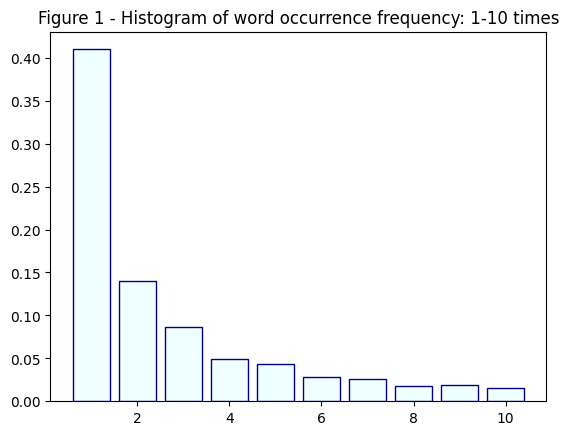

In [246]:
fig, ax = plt.subplots()
ax.bar(occurrence_frequency[:10].index, occurrence_frequency.ratio[:10], color = 'azure', edgecolor = 'darkblue')
ax.set_title('Figure 1 - Histogram of word occurrence frequency: 1-10 times')

### Frequent words among positive comments

Most frequent words in positive comments: 
temple      540
visit       413
place       344
krishna     277
icon        188
good        182
beauty      182
bangalor    177
food        168
one         166
dtype: int64


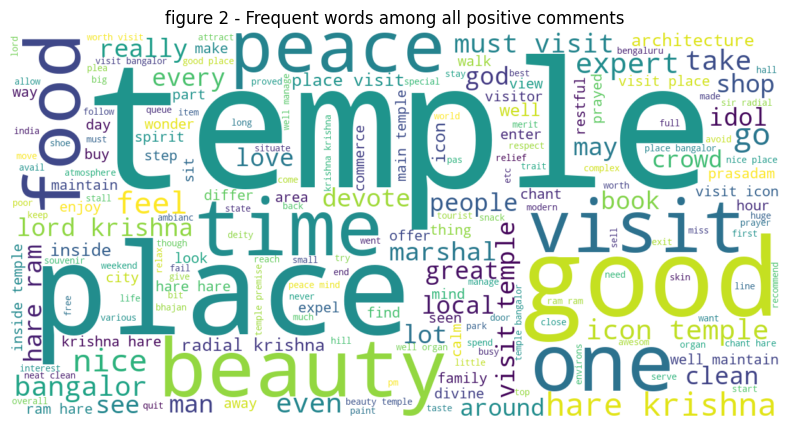

In [247]:
# words in the entire dataset: 
word_rank = one_hot_df[one_hot_df.feedback == 'POSITIVE'].iloc[:, :-2].sum(axis=0).sort_values(ascending=False)
print(f'Most frequent words in positive comments: ')
print(word_rank.head(10))

word_cloud = wc.WordCloud(width = 1200, height = 600, background_color='white').generate(" ".join(word for word in processed_data[processed_data.feedback=='POSITIVE'].joined_word))
plt.figure(figsize=(10,5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('figure 2 - Frequent words among all positive comments')
plt.show()

### Frequent words among mixed comments

Most frequent words in mixed comments: 
temple      107
visit        64
place        58
krishna      43
good         36
commerce     35
one          34
beauty       34
shop         31
like         28
dtype: int64


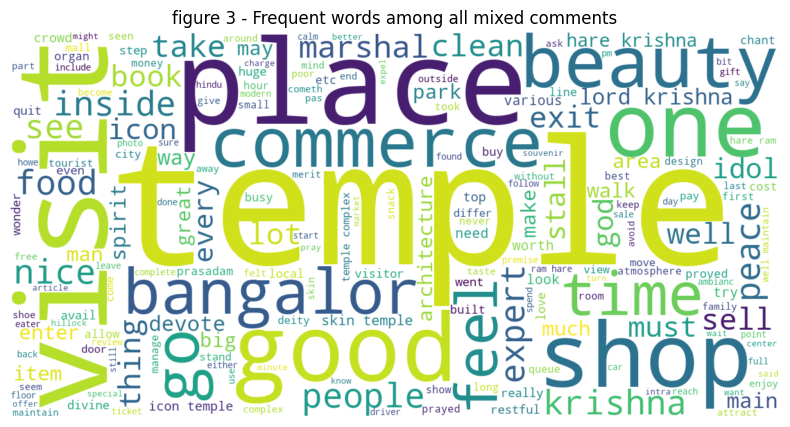

In [248]:
# words in the entire dataset: 
word_rank = one_hot_df[one_hot_df.feedback == 'MIXED'].iloc[:, :-2].sum(axis=0).sort_values(ascending=False)
print(f'Most frequent words in mixed comments: ')
print(word_rank.head(10))

word_cloud = wc.WordCloud(width = 1200, height = 600, background_color='white').generate(" ".join(word for word in processed_data[processed_data.feedback=='MIXED'].joined_word))
plt.figure(figsize=(10,5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('figure 3 - Frequent words among all mixed comments')
plt.show()

### Frequent words among negative comments

Most frequent words in negative comments: 
temple      54
visit       32
place       26
good        21
one         19
like        19
shop        17
go          17
commerce    15
krishna     14
dtype: int64


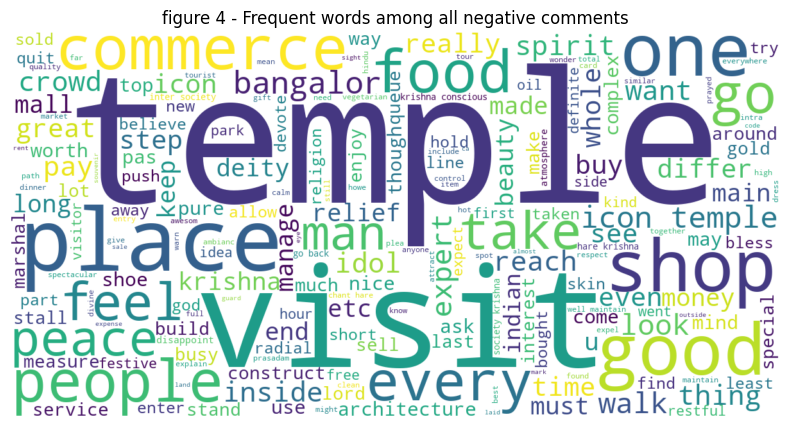

In [249]:
# words in the entire dataset: 
word_rank = one_hot_df[one_hot_df.feedback == 'NEGATIVE'].iloc[:, :-2].sum(axis=0).sort_values(ascending=False)
print(f'Most frequent words in negative comments: ')
print(word_rank.head(10))

word_cloud_n = wc.WordCloud(width = 1200, height = 600, background_color='white').generate(" ".join(word for word in processed_data[processed_data.feedback=='NEGATIVE'].joined_word))
plt.figure(figsize=(10,5))
plt.imshow(word_cloud_n, interpolation='bilinear')
plt.axis('off')
plt.title('figure 4 - Frequent words among all negative comments')
plt.show()

### TF-IDF

In [19]:
ff_vec = skl_text.TfidfVectorizer(ngram_range=(1,2))
ff_matrix = ff_vec.fit_transform(processed_data.joined_word)
ff_df = pd.DataFrame(data=ff_matrix.toarray(), columns=ff_vec.get_feature_names_out())


ff_df = pd.merge(ff_df, processed_data.feedback, left_index=True, right_index=True, how='left')

## Q5 - Supervised ML model: 

The baseline supervised learning model is established as a gradient boosting classifier that can categorize tokenized comments into one of the four sentiments: positive, negative, neutral, or mixed. THe model is trained using the previously filtered data that is divided into 60% training, 20% validation and 20% test sets. 

A total of 27 different hyperparameter configurations for the classifier is tested with different configurations on the number of estimators, the learning rate, and the maximum depth of the individual regression estimators. Training set is used to fit each of the candidate models, and the validation set is subsequently used to compute their accuracies for benchmark. The model that has the highest validation accuracy contains 100 estimators, 0.01 learning rate and a depth of 5. This proposed model has a test accuracy of 0.8. 

Note that although this test accuracy seems high, the model is inefficient in making effective classifications due to imbalanced dataset. As seen in the confusion matrix attached below, almost all the comments are classified as positive comments, while the recall rate for all other classes are very low. Data re-balancing and resampling is certainly needed to make this model more effective. 

### Dataset partition

In [21]:
x_set = ff_df.iloc[:, :-1]
y_set = ff_df.iloc[:, -1]

x_pack, x_test, y_pack, y_test = skl_msel.train_test_split(x_set, y_set, test_size=.2,random_state = 0)  
x_train, x_val, y_train, y_val = skl_msel.train_test_split(x_pack, y_pack, test_size=.2,random_state = 0)  

### Define train - validation pipeline

In [39]:
def train_val(x_train, y_train, x_val, y_val,
              n_estim: int = 100, lr: float = 0.01, depth: int = 3, random_state: int = 0): 

    config = {'estimators':n_estim, 'learning_rate':lr, 'depth': depth}

    gbc = skl_ens.GradientBoostingClassifier(n_estimators=n_estim, learning_rate=lr, max_depth=depth, random_state=random_state)
    gbc.fit(x_train, y_train)

    y_pred = gbc.predict(x_val)
    acc = skl_met.accuracy_score(y_val, y_pred)

    print(f'config: {config} acc: {acc}')

    return (gbc, n_estim, lr, depth, acc)

### Train model with candidate parameters

In [278]:
estim_option = [100,200,300]
lr_option = [0.001, 0.01,0.1]
max_depth_option = [3,4,5]
result = []

for estim_param in estim_option:
    for lr_param in lr_option:
        for depth_param in max_depth_option:
            result.append(train_val(x_train, y_train, x_val, y_val, estim_param, lr_param, depth_param))

config: {'estimators': 100, 'learning_rate': 0.001, 'depth': 3} acc: 0.7933884297520661
config: {'estimators': 100, 'learning_rate': 0.001, 'depth': 4} acc: 0.7933884297520661
config: {'estimators': 100, 'learning_rate': 0.001, 'depth': 5} acc: 0.7933884297520661
config: {'estimators': 100, 'learning_rate': 0.01, 'depth': 3} acc: 0.7933884297520661
config: {'estimators': 100, 'learning_rate': 0.01, 'depth': 4} acc: 0.7933884297520661
config: {'estimators': 100, 'learning_rate': 0.01, 'depth': 5} acc: 0.8016528925619835
config: {'estimators': 100, 'learning_rate': 0.1, 'depth': 3} acc: 0.768595041322314
config: {'estimators': 100, 'learning_rate': 0.1, 'depth': 4} acc: 0.7603305785123967
config: {'estimators': 100, 'learning_rate': 0.1, 'depth': 5} acc: 0.7603305785123967
config: {'estimators': 200, 'learning_rate': 0.001, 'depth': 3} acc: 0.7933884297520661
config: {'estimators': 200, 'learning_rate': 0.001, 'depth': 4} acc: 0.7933884297520661
config: {'estimators': 200, 'learning_rate

### Find the overall best setup

In [285]:
columns = ['model', 'estimators', 'learning rate', 'depth', 'val_accuracy']
search_result = pd.DataFrame(result[1:], columns=columns).sort_values(by='val_accuracy', ascending=False)
print('Top 5 best candidate models: ')
search_result.head()

,model,estimators,learning rate,depth,val_accuracy
4,([DecisionTreeRegressor(criterion='friedman_ms...,100,0.010,5,0.801653
20,([DecisionTreeRegressor(criterion='friedman_ms...,300,0.010,3,0.801653
11,([DecisionTreeRegressor(criterion='friedman_ms...,200,0.010,3,0.801653
0,([DecisionTreeRegressor(criterion='friedman_ms...,100,0.001,4,0.793388
17,([DecisionTreeRegressor(criterion='friedman_ms...,300,0.001,3,0.793388


### Test & Confusion matrix

Test set accuracy under the best model: 0.75


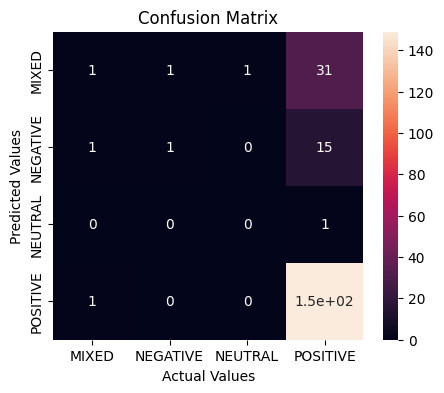

              precision    recall  f1-score   support

       MIXED       0.33      0.03      0.05        34
    NEGATIVE       0.50      0.06      0.11        17
     NEUTRAL       0.00      0.00      0.00         1
    POSITIVE       0.76      0.99      0.86       150

    accuracy                           0.75       202
   macro avg       0.40      0.27      0.26       202
weighted avg       0.66      0.75      0.66       202



In [297]:
best_model = search_result.model.iloc[0]
test_result = best_model.predict(x_test)
test_acc = skl_met.accuracy_score(y_test, test_result)
print(f'Test set accuracy under the best model: {round(test_acc,2)}')

cf_matrix=skl_met.confusion_matrix(y_test,test_result)
cf_df = pd.DataFrame(cf_matrix, index = ['MIXED', 'NEGATIVE', 'NEUTRAL', 'POSITIVE'], columns= ['MIXED', 'NEGATIVE', 'NEUTRAL', 'POSITIVE'])
plt.figure(figsize=(5,4))
sns.heatmap(cf_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Predicted Values')
plt.xlabel('Actual Values')
plt.show()

print(skl_met.classification_report(y_test,test_result))

## Q6 - Supervised ML model with rebalanced data:

All comments labelled as "neutral" has been reclassified as "mixed" since there are only 5 neutral comments inside the entire dataset, and that it lacks substantial differences compared to "mixed" comments. 

Data resampling is then done using a combined approach with SMOTE oversampling and Tomek undersampling. The rebalanced dataset contains 512 instances of positive, negative, and mixed (neutral) comments first. Similar pipeline as described in question 5 is then trained using the rebalanced dataset. Testing of the final model shows a slightly decreased overall accuracy, but it should be noticed that the recall for MIXED and NEGATIVE comments has increased substantially. 

In [130]:
x_set_reb = ff_df.iloc[:, :-1]
y_set_reb = ff_df.iloc[:, -1]
y_set_reb = pd.Series([keyword if keyword != 'NEUTRAL' else 'MIXED' for keyword in y_set_reb], name = 'feedback')

x_pack_reb, x_test_reb, y_pack_reb, y_test_reb = skl_msel.train_test_split(x_set_reb, y_set_reb, test_size=.2,random_state = 0)  
x_reb, x_val_reb, y_reb, y_val_reb = skl_msel.train_test_split(x_pack_reb, y_pack_reb, test_size=.2,random_state = 0)  

### Rebalancing via SMOTE

In [134]:
smt = imb.combine.SMOTETomek(random_state=0)
#smote = imb.over_sampling.SMOTE(random_state=0)

x_reb, y_reb = smt.fit_resample(x_reb, y_reb)

In [135]:
print(f'positive size: {y_reb[y_reb=="POSITIVE"].count()}')
print(f'negative size: {y_reb[y_reb=="NEGATIVE"].count()}')
print(f'mixed size: {y_reb[y_reb=="MIXED"].count()}')

positive size: 512
negative size: 512
mixed size: 512


In [136]:
estim_option = [100,200,300]
lr_option = [0.01,0.1]
max_depth_option = [3,4,5]
result = []

for estim_param in estim_option:
    for lr_param in lr_option:
        for depth_param in max_depth_option:
            result.append(train_val(x_reb, y_reb, x_val_reb, y_val_reb, estim_param, lr_param, depth_param))

config: {'estimators': 100, 'learning_rate': 0.01, 'depth': 3} acc: 0.7654320987654321
config: {'estimators': 100, 'learning_rate': 0.01, 'depth': 4} acc: 0.7839506172839507
config: {'estimators': 100, 'learning_rate': 0.01, 'depth': 5} acc: 0.7716049382716049
config: {'estimators': 100, 'learning_rate': 0.1, 'depth': 3} acc: 0.7839506172839507
config: {'estimators': 100, 'learning_rate': 0.1, 'depth': 4} acc: 0.7962962962962963
config: {'estimators': 100, 'learning_rate': 0.1, 'depth': 5} acc: 0.808641975308642
config: {'estimators': 200, 'learning_rate': 0.01, 'depth': 3} acc: 0.7592592592592593
config: {'estimators': 200, 'learning_rate': 0.01, 'depth': 4} acc: 0.7654320987654321
config: {'estimators': 200, 'learning_rate': 0.01, 'depth': 5} acc: 0.7716049382716049
config: {'estimators': 200, 'learning_rate': 0.1, 'depth': 3} acc: 0.8148148148148148
config: {'estimators': 200, 'learning_rate': 0.1, 'depth': 4} acc: 0.8024691358024691
config: {'estimators': 200, 'learning_rate': 0.1,

### Find the overall best setup

In [137]:
columns = ['model', 'estimators', 'learning rate', 'depth', 'val_accuracy']
reb_search_result = pd.DataFrame(result[1:], columns=columns).sort_values(by='val_accuracy', ascending=False)
print('Top 5 best candidate models (rebalanced data): ')
reb_search_result.head()

Top 5 best candidate models (rebalanced data): 


,model,estimators,learning rate,depth,val_accuracy
14,([DecisionTreeRegressor(criterion='friedman_ms...,300,0.1,3,0.820988
8,([DecisionTreeRegressor(criterion='friedman_ms...,200,0.1,3,0.814815
4,([DecisionTreeRegressor(criterion='friedman_ms...,100,0.1,5,0.808642
9,([DecisionTreeRegressor(criterion='friedman_ms...,200,0.1,4,0.802469
15,([DecisionTreeRegressor(criterion='friedman_ms...,300,0.1,4,0.802469


### Test & Confusion matrix

Test set accuracy under the best model: 0.72


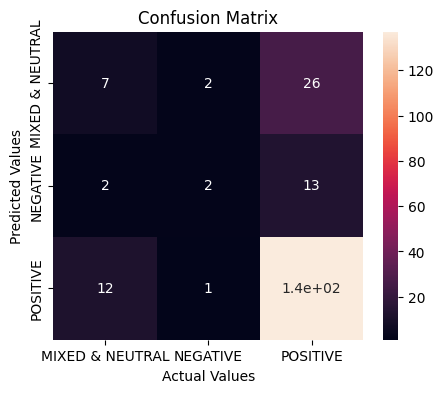

              precision    recall  f1-score   support

       MIXED       0.33      0.20      0.25        35
    NEGATIVE       0.40      0.12      0.18        17
    POSITIVE       0.78      0.91      0.84       150

    accuracy                           0.72       202
   macro avg       0.50      0.41      0.42       202
weighted avg       0.67      0.72      0.68       202



In [146]:
best_model = reb_search_result.model.iloc[0]
test_result = best_model.predict(x_test_reb)
test_acc = skl_met.accuracy_score(y_test_reb, test_result)
print(f'Test set accuracy under the best model: {round(test_acc,2)}')

cf_matrix=skl_met.confusion_matrix(y_test_reb,test_result)
cf_df = pd.DataFrame(cf_matrix, index = ['MIXED & NEUTRAL', 'NEGATIVE', 'POSITIVE'], columns= ['MIXED & NEUTRAL', 'NEGATIVE', 'POSITIVE'])
plt.figure(figsize=(5,4))
sns.heatmap(cf_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Predicted Values')
plt.xlabel('Actual Values')
plt.show()

print(skl_met.classification_report(y_test_reb,test_result))

## Q6 - Unsupervised learning: 

AFINN approach is used to evaluate the sentiment score of original comments. One particular highlight of the findings is that the sentiment score of "POSITIVE" and "NEGATIVE" labelled comments lacks statistically-significant different. As seen in figure 5, the scores of these two classes largely overlap to each other. A student t test on the distribution of the two sets of scores further proved the speculation that the manual labelling lacks statistical legitimacy (p = 0.08). 

### AFINN tests

In [144]:
afinn_data = processed_data[['feedback', 'joined_word']]
afinn_data['afinn_score'] = [Afinn().score(text) for text in afinn_data.joined_word]

### Histogram

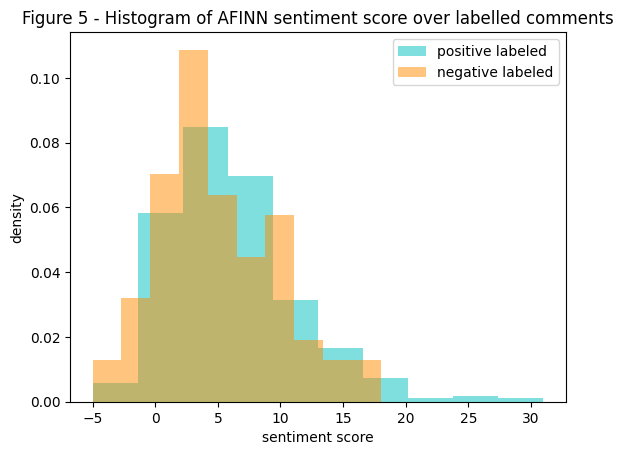

In [102]:
fig, ax = plt.subplots()
ax.hist(x=afinn_data[afinn_data.feedback=='POSITIVE'].afinn_score, density = True,
         color = 'c', alpha=0.5, label = 'positive labeled')
ax.hist(x=afinn_data[afinn_data.feedback=='NEGATIVE'].afinn_score, density = True,
         color = 'darkorange', alpha=0.5, label = 'negative labeled')

ax.set_title('Figure 5 - Histogram of AFINN sentiment score over labelled comments')
ax.set_xlabel('sentiment score')
ax.set_ylabel('density')
ax.legend()

### t-test on positive/negative labeled comments on their sentiment score

In [107]:
t, p = sp.stats.ttest_ind(afinn_data[afinn_data.feedback=='POSITIVE'].afinn_score, 
                          afinn_data[afinn_data.feedback=='NEGATIVE'].afinn_score)

if p < 0.05: 
    print(f'Significant difference in AFINN sentiment score exists between positive and negative labelled comments. p = {p:.3f}')
else: 
    print(f'THere is no significant different between AFINN sentiment scores of positive and negative labelled comments. p={p:.3f}')

THere is no significant different between AFINN sentiment scores of positive and negative labelled comments. p=0.078


## Q7 - Insights & conclusions: 

- Both the given labels and the un-supervised model proved that the comments are generally positive. 
- Though a wide array of word choices appear in the comments, there are a number of words that are omnipresent in all types of the comments. As a result, simply using one-hot encoding representing term appearance for model feature building may be insufficient. TF-IDF was therefore adopted to down-weight these frequent-in-general words. 
- As 79% of the comments are labelled as positive, building a supervised learning model to predict a comment's sentimental category based on its comment is proven challenging, as not enough comments with "NEGATIVE" or "MIXED" sentiments are available for the model to sufficiently learn the underlying relationship. Re-balance the dataset by oversampling "NEGATIVE" and "MIXED" comments while oversampling "POSITIVE" comments may help relieve the issue. 
- A model trained with rebalanced data, however, may still struggle to achieve a very high accuracy due to the overall quality of the dataset; Unsupervised learning with AFINN reveals that the given labels (which are manually labelled by workers) may not be accurate, as 'POSITIVE' comments and 'NEGATIVE' comments show no statistically-significant differences in terms of their sentiment score distributions. 